In [1]:

import torch
from exp.nb_Training import *
#from exp.nb_CNN import *

In [2]:
datasets.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160'

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160')

In [4]:
#export
from pathlib import Path
import PIL,os,mimetypes
Path.ls = lambda x: list(x.iterdir())

In [5]:
from collections import Counter

In [6]:
#example of pathlib iterdir
Counter(p.suffix for p in Path.cwd().iterdir())

Counter({'.ipynb': 15,
         '': 4,
         '.md': 1,
         '.py': 2,
         '.rar': 1,
         '.mp3': 1,
         '.txt': 1})

In [7]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [8]:
image_extensions

{'.bmp',
 '.gif',
 '.ico',
 '.ief',
 '.jpe',
 '.jpeg',
 '.jpg',
 '.pbm',
 '.pgm',
 '.png',
 '.pnm',
 '.ppm',
 '.ras',
 '.rgb',
 '.svg',
 '.tif',
 '.tiff',
 '.xbm',
 '.xpm',
 '.xwd'}

In [9]:
' '.join(image_extensions)

'.xpm .pnm .pgm .bmp .tiff .jpe .xwd .ras .ico .jpg .ppm .tif .svg .ief .rgb .xbm .gif .jpeg .pbm .png'

In [10]:
#export
def setify(o): return o if isinstance(o,set) else set(listify(o))

In [11]:
path_tench = path/'val'/'n01440764'

In [12]:
img_fn = path_tench.ls()[20]
img_fn

PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00046252.JPEG')

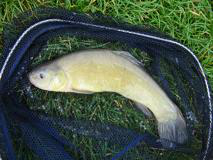

In [13]:
img = PIL.Image.open(img_fn)
img

let's walk through the directories and grab all the images. The first private function grabs all the images inside a given directory and the second one walks (potentially recursively) through all the folder in path.

In [14]:
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [ ]:
[*os.scandir(path_tench)]

In [15]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00018317.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00037383.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00011233.JPEG')]

In [ ]:
#recursively scan through the directory for all image files
t = [o.name for o in os.scandir(path_tench)]

In [ ]:
t

In [ ]:
path

In [ ]:
[*os.walk(path)] #Returns a generator object

In [ ]:
#grab all the images using the private function. Rememeber _ is just a notation. There are no actual private modifiers in Python
t = _get_files(path, t, extensions=image_extensions)

In [ ]:
t

In [16]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for p,d,f in os.walk(path): # returns (dirpath, dirnames, filenames)
            if include is not None: d[:] = [o for o in d if o in include]
            else:                   d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [ ]:
#os.walk() returns a generator object so it needs to be unpacked by iteration
next(os.walk(path_tench))

In [ ]:
get_files(path_tench, image_extensions)[:3]

In [17]:
all_fns = get_files(path, image_extensions, recurse=True)
all_fns[:5]

[PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_32588.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_32422.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_33663.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_27948.JPEG')]

In [18]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

103 ms ± 9.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Prepare for modeling
What we need to do:

Get files

Split validation set

random%, folder name, csv, ...

Label:

folder name, file name/re, csv, ...

Transform per image (optional)

Transform to tensor

DataLoader

Transform per batch (optional)

DataBunch

Add test set (optional)

In [19]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [20]:
#export
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path,self.tfms = Path(path),tfms

    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    def new(self, items): return self.__class__(items, self.path, tfms=self.tfms)
    
    def  get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)

class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)


In [21]:
#export
class Transform(): _order=0

class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')

def make_rgb(item): return item.convert('RGB')

In [22]:
il = ImageList.from_files(path, tfms=make_rgb)

In [23]:
il

ImageList (13394 items)
[PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_32422.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916

In [24]:
fn = il.items[0]; fn

PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_58454.JPEG')

In [25]:
fn.parent.parent.name

'train'

In [39]:
#export
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

def split_by_func(items, f):
    
    mask = [f(o) for o in items]
    # `None` values will be filtered out
    train = [o for o,m in zip(items,mask) if m==False]
    valid = [o for o,m in zip(items,mask) if m==True ]
    return train,valid

In [40]:
type(il)

__main__.ImageList

In [41]:
#split into train and val set. Each set should return an instance of itemList
splitter = partial(grandparent_splitter, valid_name='val')

In [42]:
splitter(il.items[100])

False

In [43]:
%time train,valid = split_by_func(il, splitter)

CPU times: user 46.9 ms, sys: 2.67 ms, total: 49.6 ms
Wall time: 49.4 ms


In [ ]:
list(zip(il.items,[False]))

In [31]:
len(train),len(valid)

(12894, 500)

In [ ]:
train[0]

In [ ]:
map(il.new,split_by_func(il, splitter))

Now that we can split our data, let's create the class that will contain it. It just needs two ItemList to be initialized, and we create a shorcut to all the unkown attributes by trying to grab them in the train ItemList.

In [44]:
#export
class SplitData():
    def __init__(self, train, valid): self.train,self.valid = train,valid
        
    def __getattr__(self,k): return getattr(self.train,k)
    #This is needed if we want to pickle SplitData and be able to load it back without recursion errors
    def __setstate__(self,data:Any): self.__dict__.update(data) 
    
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f))
        return cls(*lists)

    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [45]:
sd = SplitData.split_by_func(il, splitter); sd

SplitData
Train: ImageList (12894 items)
[PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_32422.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n0

## Labelling

Labeling has to be done after splitting, because it uses training set information to apply to the validation set, using a Processor.

A Processor is a transformation that is applied to all the inputs once at initialization, with some state computed on the training set that is then applied without modification on the validation set (and maybe the test set or at inference time on a single item). For instance, it could be processing texts to tokenize, then numericalize them. In that case we want the validation set to be numericalized with exactly the same vocabulary as the training set.

Another example is in tabular data, where we fill missing values with (for instance) the median computed on the training set. That statistic is stored in the inner state of the Processor and applied on the validation set.

In our case, we want to convert label strings in to numbers in a consistent and reproducible way. So we create a list of possible labels in the training set, and then convert our labels to numbers based on this vocab.

In [46]:
#export
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort: res.sort()
    return res

In [47]:
il.items[0].parent.name

'n03394916'

First, let's define the processor. We also define a ProcessedItemList with an obj method that can get the unprocessed items: for instance a processed label will be an index between 0 and the number of classes - 1, the corresponding obj will be the name of the class. The first one is needed by the model for the training, but the second one is better for displaying the objects.

In [61]:
#export
class Processor(): 
    def process(self, items): return items

class CategoryProcessor(Processor):
    def __init__(self): self.vocab=None
    
    def process(self, items):
        #The vocab is defined on the first use.
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    def proc1(self, item):  return self.otoi[item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    def deproc1(self, idx): return self.vocab[idx]

#This is a slightly different from what was seen during the lesson,
#   we'll discuss the changes in lesson 11
def _process(self, processors):
    self.processors = listify(processors)
    for proc in self.processors: self.items = proc.process(self.items)
    return self

def _obj(self, idx):
    res = self[idx]
    for proc in self.processors: 
        res = proc.deprocess(res) if isinstance(res,(tuple,list,Generator)) else proc.deproc1(res)
    return res

ItemList.process = _process
ItemList.obj = _obj

In [66]:
#export
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f): return [f(o) for o in ds.items]

#This is a bit different from what was seen during the lesson but it's necessary for NLP
class LabeledData():
    def __init__(self, x, y): self.x,self.y = x,y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    def __len__(self): return len(self.x)
    
    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        labels = _label_by_func(il, f)
        proc_inputs = il.process(proc_x)
        proc_labels = ItemList(labels, path=il.path).process(proc_y)
        return cls(il, proc_labels)

def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)

In [ ]:
_label_by_func(sd.train,parent_labeler)
len(_label_by_func(sd.train,parent_labeler))

In [ ]:
set(ProcessedItemList(_label_by_func(sd.train,parent_labeler), proc))

In [ ]:
proc =  CategoryProcessor()
LabeledData.label_by_func(sd.train,parent_labeler,proc)

In [63]:
labeledList = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [64]:
labeledList.train

LabeledData
x: ImageList (12894 items)
[PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_32422.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/train/n033

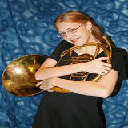

In [65]:
labeledList.train.x[20].resize((128,128))

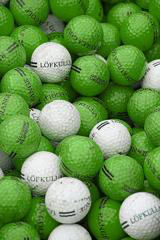

In [72]:
labeledList.train[3000][0]

In [83]:
len(labeledList.valid)

500

In [81]:
#export
class ResizeFixed(Transform):
    _order=10
    def __init__(self,size):
        if isinstance(size,int): size=(size,size)
        self.size = size
        
    def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)

def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1)
to_byte_tensor._order=20

def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order=30

In [84]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [85]:
#export
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))

In [86]:
x,y = ll.train[0]
x.shape

torch.Size([3, 128, 128])

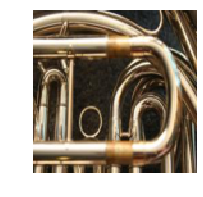

In [87]:
show_image(x)